In [19]:
import pandas as pd

df = pd.read_csv('ad_dataset.csv')

In [20]:
df.describe()

,Ad1,Ad2,Ad3,Ad4,Ad5,Ad6,Ad7,Ad8,Ad9,Ad10
count,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000,19999.000000
mean,0.128256,0.072704,0.048552,0.109255,0.120656,0.270114,0.012551,0.212611,0.170559,0.094805
std,0.334383,0.259656,0.214936,0.311967,0.325735,0.444029,0.111327,0.409165,0.376132,0.292952
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We may notice that Ad6 is the best advertisment since it has the highest CTR of 0.270114. Now I will use these values for each ad to simulate customer clicks. Clicks are Bernoulli-distributed random variables. In this example I will demonstrate Thompson sampling algorithm that uses Beta-Bernoulli model.

In [21]:
class ArmDistribution:
    a = 1
    b = 1
    
    def update_params(self, outcome):
        if outcome > 0:
            self.a = self.a + 1
        else:
            self.b = self.b + 1
            
    def sample(self):
        return np.random.beta(self.a, self.b, 1)
    
    def get_mean(self):
        return self.a / (self.a + self.b)

Below we define two main functions for Thompson sampling: first samples a value from beta distribution of each arm and chooses the arm with the highest value. The second function emulates a user behavior and uses feedback to update a posterior distribution of sampled on the previous step arm.

In [22]:
import numpy as np

def sample_arm(arms):
    best_arm = ''
    max_prob = -1.0
    for arm in arms:
        prob = arms[arm].sample()
        if prob > max_prob:
            max_prob = prob
            best_arm = arm
    return best_arm, arms[best_arm]

def play_arm_and_get_feedback(true_probability, best_arm):
    if np.random.rand(1)[0] <= true_probability:
        best_arm.update_params(1) #success
    else:
        best_arm.update_params(0) #failure

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

def plot_arms(arms):
    p = np.linspace(0, 1, 100)
    for arm in arms:
        arm_distribution = arms[arm]
        betaD = scipy.stats.beta.pdf(p, a = arm_distribution.a, b = arm_distribution.b)
        plt.plot(p, betaD, label=arm)
    plt.xlabel(r'$\theta$ |a, b')
    plt.legend()
    plt.show()
    return None

In [24]:
#this function calculates the probability that CTR for best arm is greater than CTR of all other arms
#there exists a closed form solution but simulation is much easier to understand and implement without making a mistake
def calculate_prob(arms):
    outcomes = []
    for i in range(0, 999):
        #sample from best arm distribution
        best_arm = max(arms, key=lambda k: arms[k].get_mean())
        best_arm_prob = arms[best_arm].sample()
        
        probs = []
        for arm in arms:
            if arm != best_arm:
                probs.append(arms[arm].sample())
        if best_arm_prob > max(probs):
            outcomes.append(1)
        else:
            outcomes.append(0)
    
    return np.mean(outcomes)

In [25]:
def simulate(desired_probability, num_iterations=3500):
    regrets = [0]
    prob = 0
    for i in range(1, num_iterations):
        best_arm, arm_distribution = sample_arm(arms)
        play_arm_and_get_feedback(true_probabilities[best_arm], arm_distribution)
        if (best_arm != "Ad6"):
            regrets.append(regrets[-1] + 1)
        else:
            regrets.append(regrets[-1])
        if prob < desired_probability:
            prob = calculate_prob(arms)
            if prob >= desired_probability:
                print("Experiment reached significance on " + str(i) + "-th iteration")
                plot_arms(arms)
    return regrets

In [26]:
true_probabilities = {}
arms = {}

for column in df.columns:
    true_probabilities[column] = df[column].mean()
    arms[column] = ArmDistribution()

Experiment reached significance on 139-th iteration


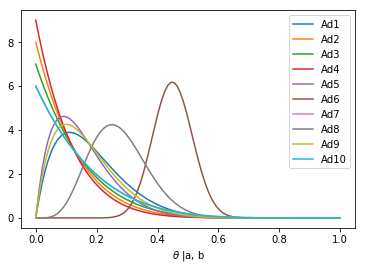

Arm distributions after 3500 iterations


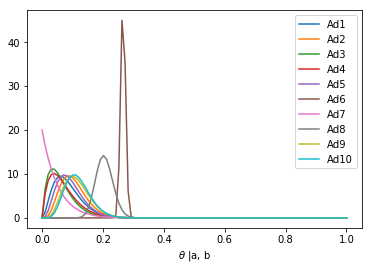

Probability that best arm has greatest CTR is: 0.960960960960961


In [27]:
regrets = simulate(0.8)
print("Arm distributions after 3500 iterations")
plot_arms(arms)
print("Probability that best arm has greatest CTR is: " + str(calculate_prob(arms)))

Here we calculate a cumulative regret. Cumulative regret here is simply how many times non-optimal advertisments were shown to the customers. If we use convential A/B test (epsilon-greedy algorithms) we will have linear cumulative regret (orange line), if we will use Thompson sampling then our cumulative regret will grow as a logarithm. It is the best theoretically possible asymptotics.

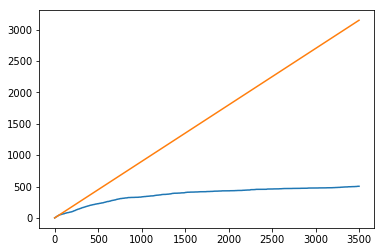

In [28]:
plt.plot(range(0, len(regrets)), regrets)
plt.plot(range(0, len(regrets)), [0.9 * x for x in range(0, len(regrets))])
plt.show()